In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

# Defining a base
Base = automap_base()

# Preparing Base / reflecting 
Base.prepare(engine , reflect= True)


In [6]:
# Viewing the tables present in hawaii.hawaii.sqlite
Base.classes.keys()

# Creating references for each table in the database
stations  = Base.classes.station # Data on weather stations in Hawai

precip = Base.classes.measurement # Data on precipitation collected by stations


In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
from sqlalchemy import desc
from sqlalchemy import asc

recent_date = session.query(precip).order_by(precip.date.desc()).all()

# Viewing the columns that exist in the precipitation table
keys = session.query(precip).order_by(precip.date.desc()).first().__dict__.keys()

#defining the structure of the dictionary object

precip_dict = {
    'id' : [] , 
    'date' : [] , 
    'prcp' : [] , 
    'station' : [] , 
    'tobs' : [] 
}

# Storing the results of the query into the precip_dict

for row in recent_date:

    precip_dict['id'].append(row.id);
    precip_dict['date'].append(row.date);
    precip_dict['prcp'].append(row.prcp);
    precip_dict['station'].append(row.station);
    precip_dict['tobs'].append(row.tobs);

# Converting dictionary object into pandas dataframe

precip_df =  pd.DataFrame(precip_dict)

# Storing the most recent date in a reference
recent_date = precip_df['date'][0];



<AxesSubplot:xlabel='date'>

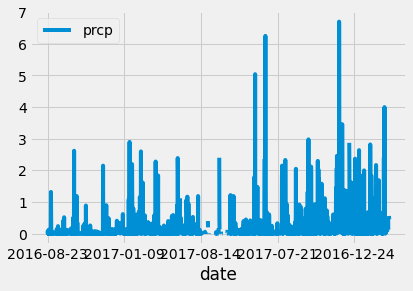

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
from datetime import timedelta

# Convert the most recent date into a datetime object
start_date = dt.datetime.strptime(recent_date , '%Y-%m-%d')

# Compute a date that is 1 year away from our most recent date
end_date = start_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
annual_prcp = session.query(precip).\
    filter(precip.date.between(dt.datetime.strftime(end_date , '%Y-%m-%d') , dt.datetime.strftime(start_date , '%Y-%m-%d')))


# Defining annual_prcp_dict structure
annual_prcp_dict = {
    'id': [] , 
    'date': [] ,
    'prcp': [] , 
    'station': [] , 
    'tobs': []
}

# Populating the annual_prcp_dict with the results of the annual_prcp query

for row in annual_prcp:
    
    annual_prcp_dict['id'].append(row.id);
    annual_prcp_dict['date'].append(row.date);
    annual_prcp_dict['prcp'].append(row.prcp);
    annual_prcp_dict['station'].append(row.station);
    annual_prcp_dict['tobs'].append(row.tobs);

# Save the query results as a Pandas DataFrame and set the index to the date column

annual_prcp_df = pd.DataFrame(annual_prcp_dict , );
annual_prcp_df = annual_prcp_df.set_index('date'); # Setting date as the index

# Sort the dataframe by date

annual_prcp_df.sort_values(by = 'date' , ascending = False)

# Use Pandas Plotting with Matplotlib to plot the data
annual_prcp_df.plot(y = 'prcp')



In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_prcp_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(stations).count();
print(f'The number of stations in Hawaii is {station_count}');


The number of stations in Hawaii is 9


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# Query joins on station id from tables Measurement and 
selection = [precip.station , stations.name , precip.tobs];

ON_station = session.query(*selection).filter(precip.station == stations.station).all()

# Storing the results as a pandas data frame

station_df = pd.DataFrame(ON_station , columns = ['Station' , 'Station_Name' , 'Temp'])

# grouping by station to get a count of rows per station
station_count_df = pd.DataFrame(station_df.groupby('Station').count())

# Sorting by descending

station_count_df.sort_values('Temp' ,ascending=False)

# the station id with the highest count (most active is: USC00519281)






,Station_Name,Temp
Station,,
USC00519281,2772,2772
USC00519397,2724,2724
USC00513117,2709,2709
USC00519523,2669,2669
USC00516128,2612,2612
USC00514830,2202,2202
USC00511918,1979,1979
USC00517948,1372,1372
USC00518838,511,511


In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
from sqlalchemy import func

max_temp = session.query(precip , func.max(precip.tobs)).filter(precip.station == 'USC00519281' ).all()
min_temp = session.query(precip , func.min(precip.tobs)).filter(precip.station == 'USC00519281').all()
avg_temp = session.query(precip , func.avg(precip.tobs)).filter(precip.station == 'USC00519281').all()

In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_query = session.query(precip).filter(precip.station == 'USC00519281')\
    .filter(precip.date\
        .between(dt.datetime.strftime(end_date , '%Y-%m-%d') , dt.datetime.strftime(start_date , '%Y-%m-%d'))).all().__dict__

# Defining dictionary structure for conversion into dictionary
most


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c90fa35ca0>,
 'prcp': 1.79,
 'station': 'USC00519281',
 'tobs': 77.0,
 'date': '2016-08-23',
 'id': 14608}

# Close session

In [15]:
# Close Session
session.close()